# Dimensionality Reduction

In this lab, we will work with the IMDB to estimate the sentiment of movie reviews. We will study PCA and Sparse PCA in this context, and work using Single Value Decomposition to perform topic analysis. In the context of text mining, we call SVD *Latent Semantic Analysis* (LSA).

LSA is already implemented in Python in scikit-learn in the package [*TruncatedSVD*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), we will use that along with the Natural Language Processing library [*NLTK*](https://www.nltk.org/) for our methods.

The general process can be summarized as follows:

1. Load the text in free form.
2. Preprocess the text to normalize it.
3. Calculate LSA.
4. Explore the results.

## Loading text: IMDB database.

This dataset comes from the website Internet Movie Database, and represents 25,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. It is a pretty big dataset, so we will work with small samples of 500 positive cases and 500 negative cases.

The uncompressed data is simply a series of text documents, each in its own text file, stored in two classes (Positive and Negative), one per folder: 

The first step is to load the data and create a "corpus". A corpus is, quite simply, a set of documents. Here, we will read the files from our folders, and assign it a sentiment. We need to read the documents one by one, and store them into a dataset which will have our texts, and the tag considering whether they are positive or negative.

### Reading the text

The first step is to read the data into a vector. We need to read from the document path, using the internal system. This package is called *os* and comes pre-installed in Python.


In [134]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from   scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from   sklearn.decomposition import PCA, SparsePCA, TruncatedSVD

# https://scikit-learn.org/stable/modules/manifold.html
from   sklearn.manifold import TSNE

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
# https://umap-learn.readthedocs.io/en/latest/
# Import umap - Install first if not available!
# !pip install umap-learn 
# !pip install datashader bokeh holoviews scikit-image colorcet ipywidgets
import umap
import umap.plot # good for plotting gigantic data

In [97]:
# Download the data
# !gdown https://drive.google.com/uc?id=15AL-2F2Vdg9xlVmHfmeIOs3opnXoxzcP

In [98]:
# !unzip LSA_Sample.zip

In [99]:
# dir = 'Lecture_Sample/train/pos/'
# os.listdir(dir)

In [100]:
# List all files in the positive samples. Replace with your own!
dir = 'Lecture_Sample/train/pos/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.DataFrame({'texts': outtexts, 'class': 1})
texts.head()

,texts,class
0,"b""If you like adult comedy cartoons, like Sout...",1
1,b'I have to admit that Tsui Hark is one of a k...,1
2,"b""Undying is a very good game which brings som...",1
3,"b""Hickory Dickory Dock was a good Poirot myste...",1
4,"b""Walter Matthau and George Burns just work so...",1


In [101]:
# Repeat for negative values
# List all files in the "pos" directory
dir = 'Lecture_Sample/train/neg/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.concat((texts, pd.DataFrame({'texts': outtexts, 'class': 0})), ignore_index = True)
texts.tail()

,texts,class
995,b'You may consider a couple of facts in the di...,0
996,b'What is this crap? My little cousin picked t...,0
997,"b""This film was choppy, incoherent and contriv...",0
998,"b""This film, once sensational for its forward-...",0
999,b'It as absolutely incredible to me that anyon...,0


In [102]:
texts.describe()

,class
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [103]:
texts

,texts,class
0,"b""If you like adult comedy cartoons, like Sout...",1
1,b'I have to admit that Tsui Hark is one of a k...,1
2,"b""Undying is a very good game which brings som...",1
3,"b""Hickory Dickory Dock was a good Poirot myste...",1
4,"b""Walter Matthau and George Burns just work so...",1
...,...,...
995,b'You may consider a couple of facts in the di...,0
996,b'What is this crap? My little cousin picked t...,0
997,"b""This film was choppy, incoherent and contriv...",0
998,"b""This film, once sensational for its forward-...",0


The text is quite dirty, so we'll use regex code to clean it. It is available in Python using the package [re](https://www.rexegg.com/regex-quickstart.html). Regex can be daunting, but it is very rewarding to learn. Do spend some time with it!

In [104]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    html = raw_html.decode('ISO-8859-1') # Change the encoding to your locale!
    cleantext = re.sub(CLEANR, '', html)
    return cleantext

texts['texts'] = texts['texts'].apply(cleanhtml)
texts

,texts,class
0,"If you like adult comedy cartoons, like South ...",1
1,I have to admit that Tsui Hark is one of a kin...,1
2,Undying is a very good game which brings some ...,1
3,Hickory Dickory Dock was a good Poirot mystery...,1
4,Walter Matthau and George Burns just work so w...,1
...,...,...
995,You may consider a couple of facts in the disc...,0
996,What is this crap? My little cousin picked thi...,0
997,"This film was choppy, incoherent and contrived...",0
998,"This film, once sensational for its forward-th...",0


Now we will transform the text. The following code uses sklearn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) which applies a [Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) transformation to the text, which means counting how many times a certain concept appears in the document versus the total times it appears in the document, to do the following:

1. Eliminate accents and other characters.
2. Eliminate the so-called "stopwords", or words that are irrelevant to the learning given they are only connectors. These words are [here](https://gist.github.com/ethen8181/d57e762f81aa643744c2ffba5688d33a).
3. Eliminate concepts that are rare (min_df) or too common (max_df). Here we eliminate concepts that appear in less than 5% of documents and those that appear in over 90%.

The last argument calculates a logaritmic (or sublinear) transformation, which is more robust. This effectively transforms our dataset into a fully numeric one!


In [105]:
# Transform the text
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.90, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

The model structure of scikit-learn follows always the same:

1. We define the model using the appropriate function directly from the package (as above).

2. We train the model using the "fit" method over the object we created in 1.

3. We apply the model to new data using the "transform" method.

In cases where we want to fit *and* transform the inputs - such as a TF-IDF transform, which is applied over the same data where the weights are "trained" - we can use directly the method "fit_transform", that performs steps 2 and 3 directly.

In [106]:
TfIDF_IMDB = TfIDFTransformer.fit_transform(texts['texts'])
TfIDF_IMDB

<1000x230 sparse matrix of type '<class 'numpy.float64'>'
	with 23848 stored elements in Compressed Sparse Row format>

1000 cases
230  words

If 23848 > 50%*(1000x230) --> you should not use sparse matrix. `TfIdfVectorizer.fit_transform()` has a `toarray()` method if needed.

It's sparse because not every word appears in every document. These matrices only store the relevant information! They are *much* more efficient in-memory.

In [122]:
df1 = pd.DataFrame(TfIDF_IMDB.toarray(), columns=TfIDFTransformer.get_feature_names_out())
df1.head()

,10,absolutely,acting,action,actor,actors,actress,actually,american,audience,...,won,wonderful,work,world,worst,worth,wrong,year,years,young
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.098920,0.136143,0.0,0.0,0.0,0.0,0.141402,0.14197,...,0.0,0.0,0.000000,0.00000,0.0,0.134697,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.126123,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.15253,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.168993,0.0,0.140479,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.154234,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.257206,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0


In [123]:
vectorizer = sktext.CountVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.90, # Eliminate words that appear in more than 95% of texts
                      )
matrix = vectorizer.fit_transform(texts['texts'])
df2 = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(df2.shape)
df2.head()

(1000, 230)


,10,absolutely,acting,action,actor,actors,actress,actually,american,audience,...,won,wonderful,work,world,worst,worth,wrong,year,years,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [124]:
# Show us the top 10 most common words
df2.sum().T.sort_values(ascending=False).head(10)

movie     1570
film      1529
like       749
just       657
good       567
story      547
time       472
really     409
people     361
great      336
dtype: int64

The output of the TF-IDF transformer is a sparse matrix. We can check the outputs of the first row with the below code.

In [132]:
print(TfIDF_IMDB[0,:])

  (0, 25)	0.26221561360196516
  (0, 102)	0.19553930525319846
  (0, 43)	0.20636328414550276
  (0, 27)	0.20986235766373093
  (0, 167)	0.2666753264211833
  (0, 79)	0.21743149588993194
  (0, 80)	0.2936185733749881
  (0, 195)	0.18088119475091288
  (0, 76)	0.2666753264211833
  (0, 87)	0.25904739767431134
  (0, 75)	0.27268042611426274
  (0, 180)	0.47280717413125994
  (0, 33)	0.24255769565192892
  (0, 107)	0.27221410897561893


In [131]:
# and we can verify:
df1.iloc[0,25]

0.26221561360196516

 The following vector shows the list of words associated to each index for indexes 30 to 39.

In [133]:
print(TfIDFTransformer.get_feature_names_out()[30:40])

# Let's save the indexes for later.
word_index = TfIDFTransformer.get_feature_names_out()

['cinema' 'classic' 'come' 'comedy' 'comes' 'completely' 'couldn' 'couple'
 'course' 'day']


## [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

An easy-to-understand [video](https://youtu.be/FgakZw6K1QQ) on SVD PCA.

You have an $n\times p$ data matrix $\boldsymbol X$, where $n$ is the number of samples and $p$ is the number of features. The singular value decomposition (SVD) of $\boldsymbol X$ gives three matrices ${USV}^T$ ($=\boldsymbol X$). Combining the first two $\boldsymbol {Z=US}$ gives the matrix of principal components. Assuming your reduced rank is $q$, then $\boldsymbol Z$ is $n \times q$. $\boldsymbol Z$ is essentially your data matrix after dimension reduction. The entries of $\boldsymbol Z$ are called variables.

On the other hand, $\boldsymbol V$ (which is $p\times q$) contains the principal loading vectors and its entries are called the principal loadings. Given the properties of PCA, one can show that $\boldsymbol {Z=XV}$. This means that the principal components are derived by using the principal loadings as coefficients in a linear combination of your data matrix $\boldsymbol X$.

Once you have all the PCs (i.e., $\boldsymbol {Z}$) figured out you can use the eigenvalues (the sum of squares of the distances from the origin - after projection) to determine the proportion of variation that each PC account for.

To a obtain a reduced dataset $\boldsymbol X_{d}$, compute the matrix multiplication of the training set matrix $\boldsymbol X$ by the matrix containing the first $d$ columns of $\boldsymbol V$ (and not $\boldsymbol V^T$).

The total explained variance of the first 2 components is 3.022 percent.


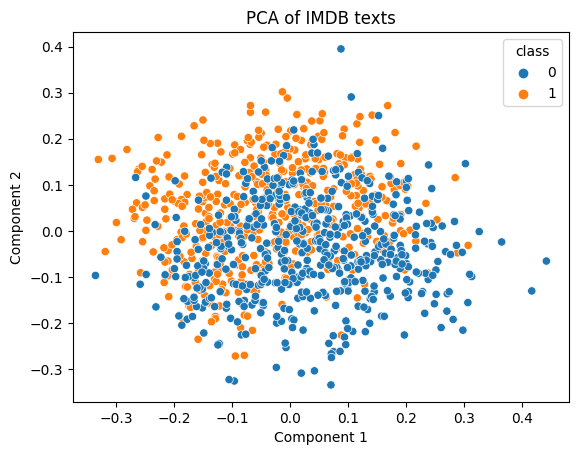

In [158]:
# Do normal PCA on the data set 
nPCA = PCA(n_components=2)

# Now we fit. We need to transform our matrix to dense format first.
nPCA.fit(TfIDF_IMDB.toarray())

# Let's calculate the variance of the two components. (lambda_i over sum of lambdas gives amount of explained variance)
total_variance = np.sum(nPCA.explained_variance_)*100
print('The total explained variance of the first %i components is %.3f percent.' % (nPCA.n_components_, total_variance))

# Let's get the components and plot them, coloring by the class
Z1 = nPCA.transform(TfIDF_IMDB.toarray())
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=texts['class'])

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of IMDB texts")
plt.show()

In [196]:
# First component words that are positive
word_index[nPCA.components_[0,:] > 0]
# if < 0 no contribution

array(['10', 'acting', 'actors', 'actually', 'awful', 'bad', 'beginning',
       'believe', 'better', 'book', 'boring', 'budget', 'came', 'camera',
       'completely', 'couldn', 'death', 'did', 'didn', 'doing', 'don',
       'dvd', 'effects', 'fan', 'favorite', 'feel', 'fun', 'funny',
       'girls', 'going', 'good', 'got', 'guy', 'hard', 'head', 'home',
       'hope', 'horror', 'instead', 'interesting', 'just', 'kind', 'know',
       'let', 'like', 'line', 'll', 'looks', 'lot', 'loved', 'low',
       'make', 'maybe', 'minutes', 'money', 'movie', 'movies', 'music',
       'nice', 'oh', 'original', 'overall', 'people', 'person', 'plot',
       'pretty', 'probably', 'problem', 'read', 'really', 'reason',
       'recommend', 'right', 'said', 'saw', 'say', 'school', 'script',
       'second', 'seeing', 'seen', 'special', 'start', 'stupid',
       'supposed', 'sure', 'terrible', 'thing', 'things', 'think',
       'thought', 'time', 'times', 'try', 'tv', 'understand', 'used',
       've', '

In [192]:
# Second component words that are positive
word_index[nPCA.components_[1,:] > 0]

array(['absolutely', 'actors', 'beautiful', 'best', 'book', 'came',
       'cast', 'characters', 'classic', 'different', 'drama', 'dvd',
       'ending', 'especially', 'excellent', 'family', 'fan', 'father',
       'favorite', 'fine', 'friends', 'fun', 'gives', 'good', 'great',
       'high', 'hollywood', 'hope', 'horror', 'interesting', 'job',
       'john', 'life', 'line', 'love', 'loved', 'movie', 'movies',
       'music', 'new', 'original', 'performance', 'performances',
       'picture', 'play', 'playing', 'read', 'recommend', 'role', 'roles',
       'saw', 'screen', 'series', 'short', 'shows', 'special', 'star',
       'stars', 'story', 'takes', 'true', 'truly', 'tv', 'use', 'watched',
       'wonderful'], dtype=object)

Even though we only explain 3% of the data we still see some separation!

 Let's see if [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) does it better.

Sparsity is enforced most of the time on the principal loadings _i.e.,_ $\boldsymbol V$. The advantage of sparsity is that a sparse $\boldsymbol V$ tells us which variables from the original $p$-dimensional feature space are worth keeping. This helps with interpretability.

Sparsity can also be enforced on the entries of $\boldsymbol Z$, but that's far less popular.

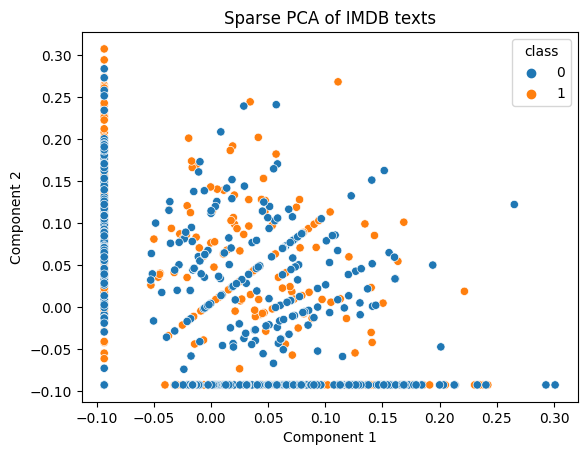

In [186]:
# Now do sparse PCA (X=ZV), enforcing sparseness on variables
# that means only a few of the original variables can appear on each latent factor 
sPCA = SparsePCA(n_components=2, random_state=0, alpha=0.5) # play with alpha to control sparsity 
sPCA.fit(TfIDF_IMDB.toarray())

# Get the results
Z2 = sPCA.transform(TfIDF_IMDB.toarray())  # This are the the Z  

# Create plot
sns.scatterplot(x=Z2[:, 0], y=Z2[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Sparse PCA of IMDB texts")
plt.show()

What happened? Given that we are forcing only some of the 230 components to be a part of the solution, this actually hurts the ability to get the components. Still, it allows to study if some components are more relevant! Now you would check which ones are actually present, like so.

In [187]:
print(sPCA.components_.shape)
# sPCA.components_

(2, 230)


In [191]:
# First component words that are positive
word_index[sPCA.components_[0,:] > 0]

array(['movie'], dtype=object)

In [190]:
# Second component words that are positive
word_index[sPCA.components_[1,:] > 0]

array(['film', 'films'], dtype=object)

As we can see, the first two components are simply referring to the same thing. People that discusses movies and films. Go back and play around with the parameters and see whether you can improve these results.

To get meaningful answers, we need to use Singular Value Decomposition.

## Running [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) Decomposition


This estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently. In particular, truncated SVD works on term count/tf-idf matrices. In that context, it is known as latent semantic analysis (LSA).
Its advantage over PCA is that it works out of the box on sparse data.


Again, we first define it using the TruncatedSVD function.

In [197]:
svd = TruncatedSVD(n_components=100, # How many concepts to extract
                   n_iter=10, # How many iterations to run
                   random_state=42 # Random state. As SVD is rotation-invariant, we need to set this
                  )

As we will apply the model to new data too, we need to first fit the model, not fit and transform simultaneously.

In [198]:
# Train the model!
svd.fit(TfIDF_IMDB)

TruncatedSVD(n_components=100, n_iter=10, random_state=42)

Now we can dig deeper into the model outputs. First, we calculate the explained variance.

In [201]:
# Get total explained variance
print(svd.explained_variance_ratio_.sum())
# svd.explained_variance_ratio_

0.6750545879823274


The explained variance is approximately $68\%$ of the total variance using 100 components.

Let's study the relationship between components and words. The matrix *components*, inside our svd object, contains the **principal component matrix**.

In [202]:
# Get component x words matrix
svd.components_

array([[ 0.07091518,  0.03669139,  0.10148825, ...,  0.04572128,
         0.07313572,  0.06054718],
       [ 0.02469028, -0.00422611,  0.0367734 , ..., -0.0275806 ,
        -0.05696519, -0.08565284],
       [-0.00426047,  0.06598763,  0.0063632 , ..., -0.00080866,
        -0.00087832,  0.01621596],
       ...,
       [ 0.02200398,  0.04105639, -0.06898358, ..., -0.04823177,
        -0.02890799,  0.06969718],
       [ 0.00106159, -0.03040192, -0.08750054, ..., -0.08395994,
         0.03279904, -0.05640795],
       [-0.00251712,  0.09233596,  0.09730665, ...,  0.01277242,
         0.03524296,  0.02042666]])

In [204]:
svd.components_.shape

(100, 230)

We can focus on particular words or concepts too. For example, for the word "action" (in place 3) we can get the following weight vector.

In [24]:
word_index[3]

'action'

In [25]:
svd.components_[:, 3]

array([ 0.04968303, -0.00586493,  0.00149491,  0.01219652,  0.06029765,
        0.08789981,  0.00438118, -0.04390307,  0.01903021,  0.07081026,
       -0.07531827, -0.014803  ,  0.03078605, -0.03655009, -0.01730266,
        0.02864627,  0.05658261,  0.07778517, -0.04695667,  0.05133611,
        0.05746947, -0.09389041, -0.05411758,  0.07876938, -0.00587168,
       -0.02469939, -0.12849947,  0.06084582, -0.08665988, -0.08593104,
       -0.08366041, -0.00155661,  0.04496287, -0.01567395, -0.09734814,
        0.02380158,  0.02991571,  0.01904849,  0.05274345,  0.09802365,
        0.04336862, -0.12061192, -0.05700096, -0.06284385, -0.08488072,
       -0.05383059, -0.11518175, -0.05212645, -0.08850133,  0.00051273,
       -0.02613511, -0.02640077,  0.13462614, -0.04051314,  0.01622875,
        0.09982405, -0.07228211, -0.11862072,  0.02231953,  0.03588646,
       -0.01007182, -0.0312966 , -0.00605721,  0.08182899,  0.0336202 ,
       -0.0436364 ,  0.00530919,  0.11472304, -0.0403414 ,  0.09

This means that the word "action" is positively related to concept 1, barely negatively related to concept 2 (i.e. that concept does *not* relate to "action"), etc.

To get the five words that relate the most with concept 2, we need to reorder and sort the vector. This can be tricky, so we will use Numpy's *argpartition* function, which will give us the **unsorted** top X values. See the discussion [here](https://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array).

In [205]:
import numpy as np

# To get the second concept, remember that Python starts indexing from 0.
indices = np.argpartition(svd.components_[1, :], -10)[-10:]
indices

array([224, 100, 195, 156,  49, 129, 214, 107, 128,  12])

In [208]:
# Get the words.
word_index[indices]

array(['worst', 'just', 'think', 'really', 'don', 'movies', 'watch',
       'like', 'movie', 'bad'], dtype=object)

As we can see, the second concept appears to relate to "bad movies". Try concept 1; it will relate to "popular movies".

The code below displays the singular values.

In [28]:
# Get singular values
svd.singular_values_

array([11.10436697,  4.12982134,  3.53931525,  3.35608758,  3.30706701,
        3.21351278,  3.13193485,  3.0311943 ,  2.99741694,  2.96551539,
        2.93676777,  2.90972563,  2.85165396,  2.82596106,  2.80612271,
        2.78801269,  2.77714358,  2.75281984,  2.74295263,  2.7199143 ,
        2.71231481,  2.68018767,  2.66353299,  2.64824751,  2.63378486,
        2.6172013 ,  2.60092833,  2.59270675,  2.57430262,  2.5591264 ,
        2.54044699,  2.52684058,  2.49827567,  2.49659147,  2.48889511,
        2.48157048,  2.4671476 ,  2.45531408,  2.44775749,  2.44320443,
        2.43184661,  2.41924638,  2.40805912,  2.39938745,  2.38900637,
        2.37804118,  2.37456016,  2.34991295,  2.34052352,  2.33187664,
        2.32375688,  2.3225587 ,  2.3144511 ,  2.29976666,  2.29730142,
        2.28533958,  2.27138478,  2.26903365,  2.25426939,  2.24344759,
        2.23543733,  2.22520432,  2.21998641,  2.21277955,  2.20696291,
        2.18608885,  2.17306345,  2.16559364,  2.15713086,  2.15

Now we have a much better way to study these concepts! Of course, now we can study particular concepts or particular words, as desired.

More importantly, we can now train a model over our reduced space, by using directly the CD matrix as our dataset!

## Non-Linear Visualization

Can we improve this analysis using non-linear methods? We will now study the use of t-Distributed Stochastic Neighbor Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP) over the data. We will use two implementations:

1. t-SNE is available in sklearn, in the [sklearn.manifold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) subpackage.
2. The more efficient UMAP is available in its own package, called [umap](https://umap-learn.readthedocs.io/en/latest/basic_usage.html).

### t-SNE

In [29]:
n_components = 2
perplexity = 50

In [30]:
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=100.0,              # Read below
                  early_exaggeration=12.0,      # Read below
                  learning_rate='auto',         # Related to above. Leave to auto
                  n_iter=5000,                  # Very important to let iterate enough
                  n_iter_without_progress=300,  # Set early stopping
                  metric='euclidean',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=42,              # Random seed
                  n_jobs=4,                     # Parallel processes
                  square_distances=True         # Square or root distances?
                 )

Some parameters in TSNE are extremely important. [This](https://distill.pub/2016/misread-tsne/) is a great paper going into detail in this regard.

In particular:

- Perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. In general, set to a high value and test a few.
- n_iter: The method must converge to be good. Set high and let the min_grad_norm and n_iter_without_progress stop the training.
- Metric: How to measure distances. Can be any keyword [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html). For text, cosine similarity is [known to work](https://academic.oup.com/bioinformatics/article/22/18/2298/318080).

The other parameters are not as significant. Let's train the model!



In [31]:
TSNE_embedding = tSNEmapper.fit_transform(TfIDF_IMDB)

/home/alireza/ml/my_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:830: FutureWarning: The parameter `square_distances` has not effect and will be removed in version 1.3.
  warnings.warn(


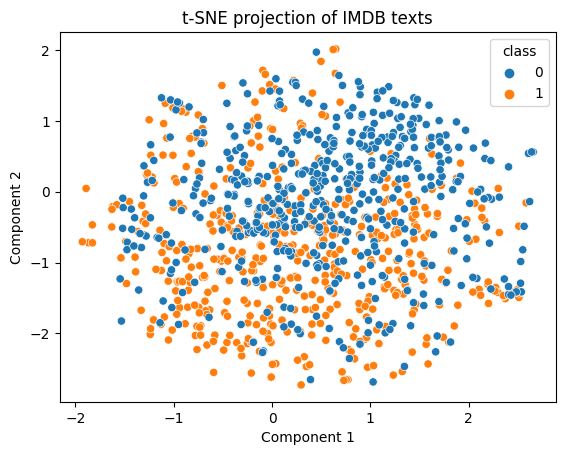

In [32]:
# Create plot
sns.scatterplot(x=TSNE_embedding[:, 0], y=TSNE_embedding[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of IMDB texts")
plt.show()

We can see that the non-linear projection does help separate some of the classes better than PCA. Play around with the parameters to get a better result!

### UMAP

UMAP (Uniform Manifold Approximation and Projection) is a more sophisticated model based on solid mathematical principles. They are fairly sophisticated, so if you want to check them out in detail, read the [original paper](https://arxiv.org/abs/1802.03426). In particular, Appendix C is of great use if you are familiar with Machine Learning notation.

UMAP is far more efficient than t-SNE, particularly when projecting into more than two dimensions, so it is generally a better method than t-SNE. It is, however, still not very mainstream.

Let's create a 2D projection of our data using UMAP, that works great with sparse matrices.

In [33]:
# Let's create the object
reducer = umap.UMAP(n_neighbors=15,              # Number of neareast neighbours to use. 
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='hellinger',          # Metric to use.
                    n_epochs=None,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=42,             # Random seed
                    verbose=True                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(TfIDF_IMDB)

UMAP(angular_rp_forest=True, metric='hellinger', random_state=42, verbose=True)
Thu Nov 24 13:33:27 2022 Construct fuzzy simplicial set
Thu Nov 24 13:33:27 2022 Finding Nearest Neighbors
Thu Nov 24 13:33:29 2022 Finished Nearest Neighbor Search
Thu Nov 24 13:33:31 2022 Construct embedding


/home/alireza/ml/my_env/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 74358 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Epochs completed:   0%|            0/500 [00:00]

Thu Nov 24 13:33:33 2022 Finished embedding


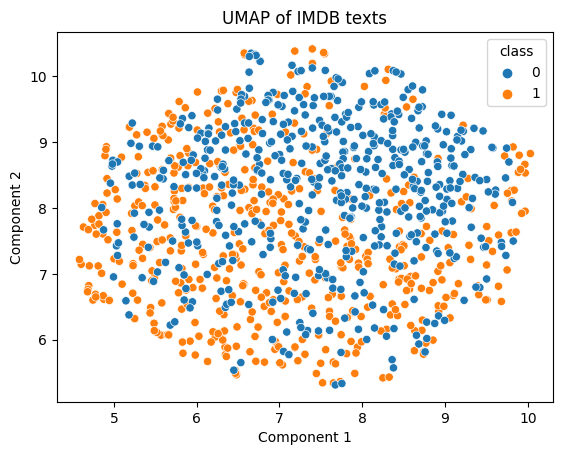

In [34]:
# Create plot
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of IMDB texts")
plt.show()

Or alternatively (and using way less memory) we can simply plot the mapper directly.

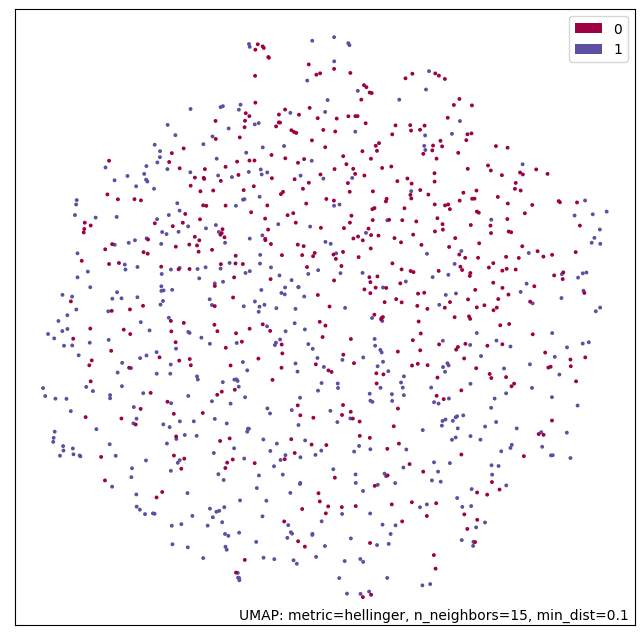

In [35]:
umap.plot.points(reducer, labels=texts['class'])
plt.show()

UMAP and t-SNE create much sparser divisions, and one that clearly separates both classes! What we can infer is that there is a significant non-linear separation between these two movie reviews, and that this can be correctly interpreted using non-linear models.